# 3 - Network Simulation I

In this tutorial you will be expose to the basic working of the `simulation()` function that can be found within the 'simulate' module of the **NetSim** package.  

### imports

In [1]:
import netsim.generate as ng
import netsim.utils as utils
import netsim.simulate as ns
import geopandas as gpd
import numpy as np
from pathlib import Path

### Set data path

In [ ]:
data_path = Path.cwd().parent / "data"

### Reading files

#### *Read DEM*

In [2]:
fn_dem = data_path / "sample" / "sampleDEM.tif"

In [3]:
dem, profile = utils.read_raster(fn_dem)

In [4]:
#find the cellsize of the dem
cellsize = profile['transform'].a

#### *Read shapefile into a geopandas dataframe*

In [5]:
fn_shp = data_path / "sample" / "sample5.shp"

##### read and make a copy of original dataframe

In [6]:
df_temp = gpd.read_file(fn_shp)

# make a copy
df = df_temp.copy(deep=True)
df

,id,seq,group,mix,easting,northing,geometry
0,0,1,1,0,530782,4389390,POINT (530782 4389390)
1,1,1,1,0,531119,4388860,POINT (531119 4388860)
2,2,1,1,0,530403,4388580,POINT (530403 4388580)
3,3,1,1,0,530503,4388620,POINT (530503 4388620)
4,4,1,1,0,530729,4388930,POINT (530729 4388930)
5,5,1,1,0,530606,4389150,POINT (530606 4389150)


### Preliminaries

#### *Convert point coordinates into rows and column and add to dataframe*

In [7]:
df['r'], df['c'] = utils.pt2rc(df['geometry'], profile)
df

,id,seq,group,mix,easting,northing,geometry,r,c
0,0,1,1,0,530782,4389390,POINT (530782 4389390),18,104
1,1,1,1,0,531119,4388860,POINT (531119 4388860),124,171
2,2,1,1,0,530403,4388580,POINT (530403 4388580),180,28
3,3,1,1,0,530503,4388620,POINT (530503 4388620),172,48
4,4,1,1,0,530729,4388930,POINT (530729 4388930),110,93
5,5,1,1,0,530606,4389150,POINT (530606 4389150),66,68


#### *Plot locations*

In [8]:
hillshade = utils.calculate_hillshade(dem)

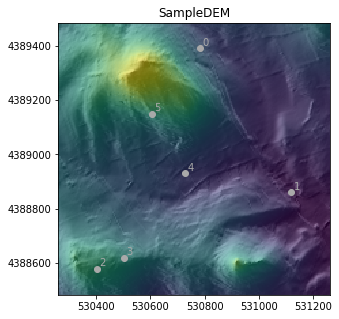

In [9]:
utils.plot_map(raster = {'ras':dem, 'profile':profile, 'bground': hillshade},
               loc= {'df': df, 'label': 'id'},
               title='SampleDEM')

### create one iteration

In [10]:
# check values
df = ng.check(df)


 No corrections or errors !! 


In [11]:
# create network generator
netgentor, net_info, total_iterations = ng.create_network_generator(df)


 iteration broken per group....

   group  num_loc  num_iter iter_type
0      1        6       100    sample

 total number of iterations.... 100


In [12]:
# generate one sample iteration
iter_id = 1
net_iteration = list(next(netgentor))
print('\nfirst iteration: ',net_iteration)


first iteration:  [(3, 5, 4, 1, 2, 0)]


In [13]:
# create path network layout for iteration
df_net = ng.network_layout(df, net_iteration, iter_id, opt='all')
df_net

,origin,destination,iteration
0,3,5,1
1,3,4,1
2,3,1,1
3,3,2,1
4,3,0,1
5,5,4,1
6,5,1,1
7,5,2,1
8,5,0,1
9,4,1,1


## Simulation

##### *find coefficients for gradient to cost function*

In [14]:
# vertical factor table
vftfn = data_path / "iwdt" / "grad2cost.csv"

# read file slope (tan) to cost
vft = np.genfromtxt(vftfn, delimiter=',')

In [15]:
# fit values to 4th degree polynomial and return coefficients
coef = np.polyfit(np.tan(np.radians(vft[: , 0])), vft[:,1], deg=4)
coef

array([ 14.58472386, -20.89105302,  41.30992529,  16.89952776,
         2.57058679])

#### Set up cost dictionary

In [16]:
cost_dict={
    'dem': dem,
    'netcost': np.zeros_like(dem), # generate a blank initial netcost
    'cellsize': cellsize,
    'weight': 0.2,
    'coef': coef
}

#### Set up netsim dictionary

##### *calculate $\alpha$ for given $d_0$ and $NC_0$*

We shall specify that at a distance of $d_0$=10m the network cost (i.e. the effect of the existing network) will decrease to $\frac{1}{2} $.  

In [17]:
from math import log

In [18]:
d0 = 10 # distance @ which 
NC0 = 0.5  # cost is only beta
alpha = d0 / log(1- NC0)

In [19]:
netsim_dict= {
    'i': 1.0,      # path impact
    'Gmax': 5.0,   # path saturation
    'T': 10,     # residuality 
    'alpha': alpha # decay factor 
    }

#### Run a single simulation

In [20]:
g, paths, _ = ns.simulation(df, df_net, cost_dict, netsim_dict)

##### Plot results

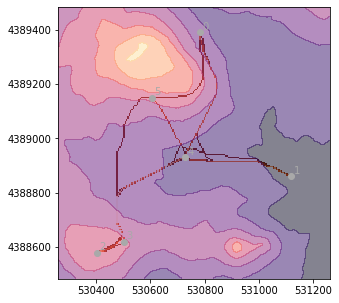

In [21]:
utils.plot_map(raster= {'ras':dem, 'profile':profile, 'paths':paths},
               loc={'df':df, 'label':'id'},
               cmap='magma')

### Varying residuality

The parameter $T$ controls the *residuality* or *lingering* of the path network. $T$ corresponds to the number of timesteps that have to pass before the effect of the existing network is reduced by $\frac{G_{t-1}}{T}$. $T$ can only have values that are $\ge$1. The larger $T$ the more the effect of the entire network (not just those sections that are well trodden) will be noticeable. 

In [24]:
Ts = [1, 3, 5, 10, 15]

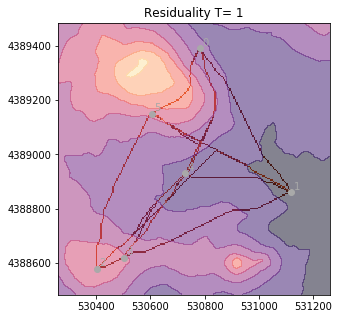

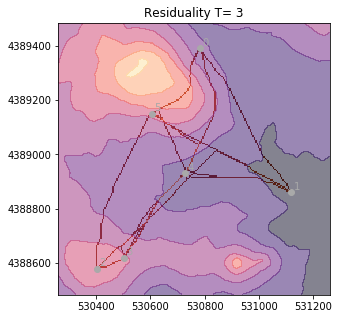

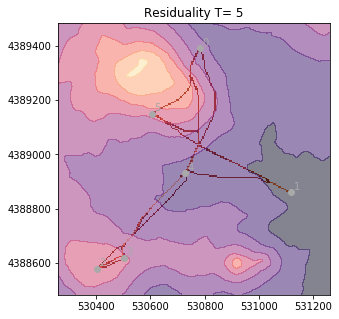

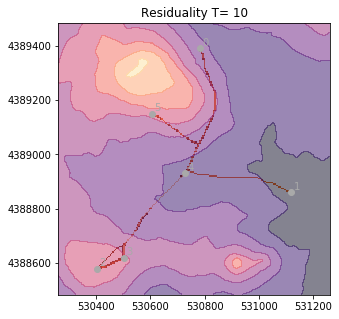

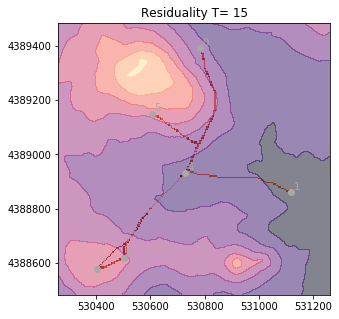

In [25]:
# set weight to 0.5
cost_dict['weight'] = 0.5

for T in Ts:
    # Change the residuality
    netsim_dict['T'] = T
    
    # run simulation
    g, paths, _ = ns.simulation(df, df_net, cost_dict, netsim_dict)
    
    # printout results
    utils.plot_map(raster = {'ras':dem, 'profile':profile, 'paths':paths},
                   loc = {'df':df, 'label':'id'},
                   cmap ='magma',
                   title = 'Residuality T= '+ str(T))